# USDA Food Desert definition 
(based on Characteristics and Influential Factors of Food Deserts)  

https://www.ers.usda.gov/publications/pub-details?pubid=45017

## A census bloc is a food desert if it is both:
1. **Low-Income** (poverty ≥20%)
2. And **Low-Access** (access >1 mile (urban) or >10 miles (rural) from a supermarket)

In [26]:
import pandas as pd
import re
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from dataprocessing import get_blockgroupshape, get_foodswamp_data, get_blockgroup_data

In [54]:
# importing dfs
blockgroup_shapefile = get_blockgroupshape()
food_swamp_df = get_foodswamp_data()
blockgroup_data_df = get_blockgroup_data()

In [55]:
USDA_def = pd.merge(blockgroup_data_df, blockgroup_shapefile,left_on='Geo Index', right_on='GEOIDFQ', how='inner')
#print(len(USDA_def),len(blockgroup_data_df),len(blockgroup_shapefile))

In [56]:
# poverty_le20 flag
USDA_def['poverty_le20'] = USDA_def['Percent Poverty Level'].apply(lambda x: 1 if x >= 0.20 else 0)

# low_access flag:
USDA_def['low_access'] = (
    ((USDA_def['Classification'] == 'Urban') & (USDA_def['Distance_mi'] > 1)) |
    ((USDA_def['Classification'] == 'Rural') & (USDA_def['Distance_mi'] > 10))).astype(int)

# USDA definition flag
USDA_def['USDA_def_flag'] = ((USDA_def['poverty_le20'] == 1) & (USDA_def['low_access'] == 1)).astype(int)

print((USDA_def['USDA_def_flag'] == 1).sum())
print((USDA_def['USDA_def_flag'] == 0).sum())

(USDA_def['USDA_def_flag'] == 1).sum() / ((USDA_def['USDA_def_flag'] == 0).sum()+(USDA_def['USDA_def_flag'] == 1).sum())

1481
17157


np.float64(0.0794613155918017)

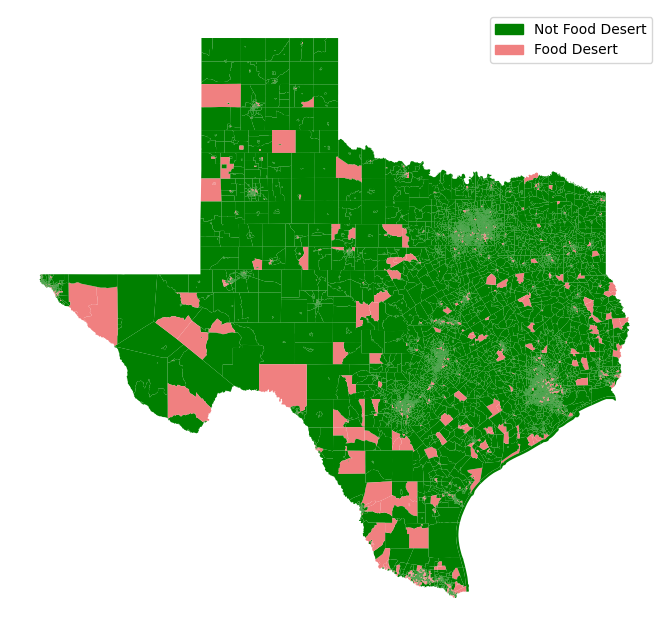

In [57]:
# converting  USDA_def to a GeoDataFrame 
USDA_def = gpd.GeoDataFrame(USDA_def, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['green', 'lightcoral'])  # green for 0, lightcoral (red) for 1

USDA_def.plot(column='USDA_def_flag', cmap=cmap, legend=False, ax=ax)
ax.set_axis_off()

# create custom legends using patches 
not_fd_patch = mpatches.Patch(color='green', label='Not Food Desert')
fd_patch = mpatches.Patch(color='lightcoral', label='Food Desert')

plt.legend(handles=[not_fd_patch, fd_patch], loc='upper right')

plt.show()